## Setup

In [1]:
from __future__ import division, print_function, absolute_import

In [2]:
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
sns.set()

/usr/local/manual/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
from lsst.sims.catalogs.measures.instance import InstanceCatalog
import lsst.sims.catUtils.baseCatalogModels as bcm
from lsst.sims.catalogs.generation.db import CatalogDBObject, DBObject
from lsst.sims.catUtils.baseCatalogModels.GalaxyModels import GalaxyTileObj, GalaxyObj
from lsst.sims.utils import ObservationMetaData

/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 25 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')
/Users/rbiswas/src/LSST/sims_catalogs_generation/python/lsst/sims/catalogs/generation/db/dbConnection.py:438: UserWarning: Duplicate object type id 40 specified: 
Output object ids may not be unique.
This may not be a problem if you do not want globally unique id values
  'want globally unique id values')


## Catalogs

Usual observation MetaData, for galaxy Tile. Note that this is shifted from the galaxy Base by a simple rotation along phi of size 2 degrees. We consider two Observation Meta Data boxes one which gives the base tile and one which is 4 degrees South. 

In [5]:
# This is a tile on galaxyTiled which is shifted only in RA from the base patch
observerMetaData = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=0.,
                                  boundLength=0.1)

In [6]:
# A tile on galaxyTiled shifted from the previous one by 4 degrees to the South
observerMetaData_1 = ObservationMetaData(boundType='box',
                                  pointingRA=2.,
                                  pointingDec=-4.,
                                  boundLength=0.1)

In [7]:
# Since we have to write out stuff to a csv file, we increase the angular precision to 0.16f
class galCopy(InstanceCatalog):
    column_outputs = ['galtileid', 'raJ2000', 'decJ2000', 'redshift', 'mass_stellar', 'absmag_r_total']#, 'a_d', 'b_d', 'pa_disk', 'mass_stellar', 'absmag_r_total']
    override_formats = {'raJ2000': '%0.16f', 'decJ2000': '%0.16f', 'a_d': '%8e', 'b_d': '%8e', 'pa_disk': '%8e', 
                        'mass_stellar': '%8e', 'absmag_r_total': '%8e'}

In [8]:
def galIds(tileID, galTileID):
    """
    Function to convert galTileID to ID using the tileID
    
    Parameters
    ----------
    tileID : int, mandatory
        ID of the tile
    galTileID: int, mandatory
        galtileid of the galaxy
    """
    return galTileID - 100000000* tileID

In [9]:
galaxyTiled = GalaxyTileObj()

/usr/local/manual/anaconda/lib/python2.7/site-packages/sqlalchemy/dialects/mssql/base.py:1294: SAWarning: Did not recognize type 'geography' of column 'geopoint'
  return fn(*arg, **kw)


In [10]:
def myarccos(cosine):
    sinsqhalftheta= 0.5*(1.0 - cosine)
    sinhalftheta = np.sqrt(sinsqhalftheta)
    return 2.0 *np.arcsin(sinhalftheta)
    #return sinsqhalftheta

In [11]:
milliarcsec = np.float64(1.0e-3/60./ 60. * np.pi/180.)

In [12]:
#fig, ax = plt.subplots()
rads = np.arange(0., np.pi, 0.000001)
cosvals =  np.cos(rads)
theta = myarccos(cosvals)
phis = np.arccos(cosvals)
ax.plot(cosvals, np.arccos(cosvals)/rads - 1.,'.')
ax.plot(cosvals, theta/rads - 1.,'r.')
#ax.set_xscale('log')

NameError: name 'ax' is not defined

In [ ]:
from decimal import Decimal

In [13]:
def angSep( df1 , df2,  theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values
    # Take the dot product
    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    # Calculate arccos differently to avoid loss of precision
    #sinhalftheta = np.sqrt(0.5*(1.0 - cos))
    #return 2.*(np.arcsin(sinhalftheta))
    return cos, myarccos(cos)

In [14]:
def rotation(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    # spherical polar
    df['theta'] = - df['decJ2000'] + np.pi/2.
    df['phi'] = df['raJ2000'] - np.radians(2.)
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    yprime = sintheta * sinphi
    
    rlat = np.sqrt(xprime **2. + yprime **2.)
    #rlat = np.sqrt(1.0 - zprime**2)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    # df[phiprime] = np.arccos(xprime / rlat) - np.radians(2.)
    df[phiprime] = np.arcsin(yprime / rlat) + np.radians(2.)
    
    #df['x'] = sintheta * cosphi
    #df['y'] = sintheta * sinphi
    #df['z'] = costheta
    #df['xprime'] = xprime
    #df['yprime'] = yprime
    #df['zprime'] = zprime
    #df[thetaprime] = np.arccos(zprime)
    df[thetaprime] = myarccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

#### On Base Patch

In [15]:
# Read the two tiles into pd.DataFrames

In [16]:
constr='redshift < 0.4'
gBase = galCopy(galaxyTiled, obs_metadata=observerMetaData, constraint=constr)
gBase.write_catalog('gBase.csv')
#, defaultfmt='%.16f')
gBase_df  = pd.read_csv('gBase.csv', delimiter=', ', index_col='#galtileid', engine='python')
gBase_df.index.name = 'galtileid'
#cols = gBase_df.columns
#aliasCols = {x:x.strip() for x in cols}
#gBase_df.rename(columns=aliasCols, inplace=True)
#gBase_df = pd.DataFrame(tmp)
gBase_df.head()

,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total
galtileid,,,,,
2209932244,0.034950,-0.000120,0.1995,0.000161,-13.24359
2201788073,0.034923,-0.000554,0.1964,0.002476,-15.88512
2201787850,0.035353,-0.000105,0.1835,0.002417,-15.63991
2200394567,0.035337,-0.000311,0.2112,0.069907,-18.30111
2211503240,0.035103,-0.000191,0.1947,0.000087,-13.10250


In [17]:
!head gBase.csv

#galtileid, raJ2000, decJ2000, redshift, mass_stellar, absmag_r_total
2209932244, 0.0349504887962718, -0.0001196091574396, 0.1995, 1.607000e-04, -1.324359e+01
2201788073, 0.0349234676092677, -0.0005537266514773, 0.1964, 2.475600e-03, -1.588512e+01
2201787850, 0.0353531414987872, -0.0001045417351543, 0.1835, 2.417100e-03, -1.563991e+01
2200394567, 0.0353368715415857, -0.0003107157377323, 0.2112, 6.990660e-02, -1.830111e+01
2211503240, 0.0351034145394514, -0.0001914294625674, 0.1947, 8.700000e-05, -1.310250e+01
2206214440, 0.0352063034372487, -0.0000989270068022, 0.2044, 1.809700e-03, -1.433908e+01
2200154803, 0.0350872720024102, -0.0002457371266044, 0.2117, 4.579330e-02, -1.908944e+01
2203734515, 0.0355689130729511, -0.0008379954310797, 0.1875, 2.979500e-03, -1.484655e+01
2217340254, 0.0349765325985606, -0.0010479166332991, 0.2149, 1.820000e-05, -1.189331e+01


In [18]:
type(gBase_df.ix[2209932244, 'raJ2000'])

numpy.float64

In [19]:
%precision 32
gBase_df.ix[2209932244, 'raJ2000']

0.03495048879627180027362953751435

In [20]:
# reset the id to 
gBase_df['id'] = galIds(22, gBase_df.index.values)
gBase_df.reset_index(inplace=True)
gBase_df.set_index('id', inplace=True)
gBase_df.head()

,galtileid,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total
id,,,,,,
9932244,2209932244,0.034950,-0.000120,0.1995,0.000161,-13.24359
1788073,2201788073,0.034923,-0.000554,0.1964,0.002476,-15.88512
1787850,2201787850,0.035353,-0.000105,0.1835,0.002417,-15.63991
394567,2200394567,0.035337,-0.000311,0.2112,0.069907,-18.30111
11503240,2211503240,0.035103,-0.000191,0.1947,0.000087,-13.10250


#### On a Tile 4 degrees South

In [21]:
gTile_1 = galCopy(galaxyTiled, obs_metadata=observerMetaData_1, constraint=constr)
gTile_1.write_catalog('gTile_1.csv')
gTile1_df  = pd.read_csv('gTile_1.csv', delimiter=', ', index_col='#galtileid', engine='python')
gTile1_df.index.name = 'galtileid_1'
#cols = gTile1_df.columns
#aliasCols = {x:x.strip() for x in cols}
#gTile_df.rename(columns=aliasCols, inplace=True)
gTile1_df.head()

,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total
galtileid_1,,,,,
2109932244,0.034951,-0.069933,0.1995,0.000161,-13.24359
2101788073,0.034924,-0.070367,0.1964,0.002476,-15.88512
2101787850,0.035354,-0.069918,0.1835,0.002417,-15.63991
2100394567,0.035338,-0.070124,0.2112,0.069907,-18.30111
2111503240,0.035104,-0.070005,0.1947,0.000087,-13.10250


In [22]:
!head gTile_1.csv

#galtileid, raJ2000, decJ2000, redshift, mass_stellar, absmag_r_total
2109932244, 0.0349505963728822, -0.0699327791698189, 0.1995, 1.607000e-04, -1.324359e+01
2101788073, 0.0349235094901067, -0.0703668967212848, 0.1964, 2.475600e-03, -1.588512e+01
2101787850, 0.0353542352164480, -0.0699177048427305, 0.1835, 2.417100e-03, -1.563991e+01
2100394567, 0.0353379316292574, -0.0701238793440136, 0.2112, 6.990660e-02, -1.830111e+01
2111503240, 0.0351038978182583, -0.0700045981877754, 0.1947, 8.700000e-05, -1.310250e+01
2106214440, 0.0352070373974102, -0.0699120939457518, 0.2044, 1.809700e-03, -1.433908e+01
2100154803, 0.0350877163340403, -0.0700589060648804, 0.2117, 4.579330e-02, -1.908944e+01
2103734515, 0.0355705693184209, -0.0706511501722628, 0.1875, 2.979500e-03, -1.484655e+01
2117340254, 0.0349767085418451, -0.0708610865419956, 0.2149, 1.820000e-05, -1.189331e+01


In [23]:
gTile1_df.ix[2109932244, 'raJ2000']

0.03495059637288219778206155297084

In [24]:
gTile1_df['id'] = galIds(21, gTile1_df.index.values)
gTile1_df.reset_index(inplace=True)
gTile1_df.set_index('id', inplace=True)
gTile1_df.rename(columns={'raJ2000':'raJ2000_1', 'decJ2000':'decJ2000_1', 'redshift': 'redshift_1',
                          'mass_stellar':'mass_stellar_1', 'absmag_r_total':'absmag_r_total_1'},
                 inplace=True)
gTile1_df.head()

,galtileid_1,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1
id,,,,,,
9932244,2109932244,0.034951,-0.069933,0.1995,0.000161,-13.24359
1788073,2101788073,0.034924,-0.070367,0.1964,0.002476,-15.88512
1787850,2101787850,0.035354,-0.069918,0.1835,0.002417,-15.63991
394567,2100394567,0.035338,-0.070124,0.2112,0.069907,-18.30111
11503240,2111503240,0.035104,-0.070005,0.1947,0.000087,-13.10250


We will merge the two dataFrames, using the ids of the galaxy calculated from the galtileID and the knowledge of the tileID. We look up the tileID for the two tiles as 22, 21 respectively.

In [25]:
merged =  pd.concat([gBase_df, gTile1_df], axis=1)

In [26]:
merged.head()

,galtileid,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total,galtileid_1,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1
id,,,,,,,,,,,,
259,2200000259,0.033403,0.001036,0.1728,0.009030,-15.33565,2100000259,0.033400,-0.068777,0.1728,0.009030,-15.33565
371,2200000371,0.036230,-0.000562,0.0421,0.416331,-19.77124,2100000371,0.036233,-0.070375,0.0421,0.416331,-19.77124
416,2200000416,0.034866,0.000352,0.0544,2.260572,-21.29976,2100000416,0.034866,-0.069461,0.0544,2.260572,-21.29976
1083,2200001083,0.034761,-0.001270,0.1438,18.788060,-23.22925,2100001083,0.034761,-0.071083,0.1438,18.788060,-23.22925
1605,2200001605,0.034287,-0.000954,0.0545,1.074812,-20.27710,2100001605,0.034285,-0.070767,0.0545,1.074812,-20.27710


How many galaxies in one which are not in the other? Ideally, I think this number should be zero. In the following plot, these points are labelled in blue.

In [27]:
uncommon = merged[merged.isnull().any(axis=1)].copy()

In [28]:
len(uncommon)

4

In [29]:
uncommon[['raJ2000', 'decJ2000']].apply(lambda x: x - np.radians(2.))

,raJ2000,decJ2000
id,,
655425,-0.001742,-0.033653
3241089,0.001744,-0.034328
7396529,-0.001742,-0.035240
11624745,-0.001743,-0.035440


In [30]:
len(merged)

2284

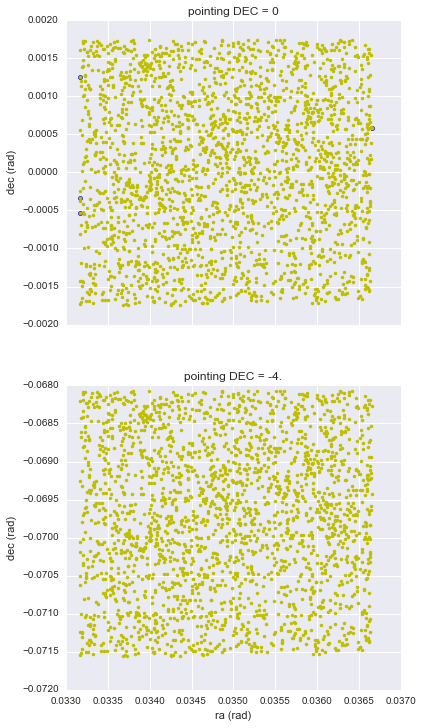

In [36]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12), sharex=True, squeeze=True)
ax[0].plot(merged.raJ2000, merged.decJ2000, 'y.')
ax[0].scatter(uncommon.raJ2000, uncommon.decJ2000, color='b')
ax[1].plot(merged.raJ2000_1, merged.decJ2000_1, 'y.')
ax[1].scatter(uncommon.raJ2000_1, uncommon.decJ2000_1, color='r')
ax[0].set_ylabel('dec (rad)')
ax[1].set_ylabel('dec (rad)')
ax[1].set_xlabel('ra (rad)')
ax[0].set_title('pointing DEC = 0')
ax[1].set_title('pointing DEC = -4.')

In [32]:
print(len(uncommon)/2., (len(gBase_df) + len(gTile1_df) )/2.)

2.0 2282.0


In [37]:
np.sqrt(2228.)

47.20169488482378739035993930883706

## Tests Galaxies are correctly identified

In [38]:
common = merged[~merged.isnull().any(axis=1)]

In [39]:
np.allclose(common.redshift, common.redshift_1)

True

In [40]:
np.allclose(common.mass_stellar, common.mass_stellar_1)

True

In [41]:
np.allclose(common.absmag_r_total, common.absmag_r_total_1)

True

In [42]:
print(len(common))

2280


In [43]:
common.head()

,galtileid,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total,galtileid_1,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1
id,,,,,,,,,,,,
259,2200000259,0.033403,0.001036,0.1728,0.009030,-15.33565,2100000259,0.033400,-0.068777,0.1728,0.009030,-15.33565
371,2200000371,0.036230,-0.000562,0.0421,0.416331,-19.77124,2100000371,0.036233,-0.070375,0.0421,0.416331,-19.77124
416,2200000416,0.034866,0.000352,0.0544,2.260572,-21.29976,2100000416,0.034866,-0.069461,0.0544,2.260572,-21.29976
1083,2200001083,0.034761,-0.001270,0.1438,18.788060,-23.22925,2100001083,0.034761,-0.071083,0.1438,18.788060,-23.22925
1605,2200001605,0.034287,-0.000954,0.0545,1.074812,-20.27710,2100001605,0.034285,-0.070767,0.0545,1.074812,-20.27710


## Angular Separations

In [44]:
%timeit rotation(common, delta=1)

/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/manual/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pan

1 loops, best of 3: 272 ms per loop


In [45]:
common.head()

,galtileid,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total,galtileid_1,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1,theta,phi,phiprime_1,thetaprime_1
id,,,,,,,,,,,,,,,,
259,2200000259,0.033403,0.001036,0.1728,0.009030,-15.33565,2100000259,0.033400,-0.068777,0.1728,0.009030,-15.33565,1.569761,-0.001503,0.033400,1.639574
371,2200000371,0.036230,-0.000562,0.0421,0.416331,-19.77124,2100000371,0.036233,-0.070375,0.0421,0.416331,-19.77124,1.571358,0.001323,0.036233,1.641171
416,2200000416,0.034866,0.000352,0.0544,2.260572,-21.29976,2100000416,0.034866,-0.069461,0.0544,2.260572,-21.29976,1.570444,-0.000041,0.034866,1.640258
1083,2200001083,0.034761,-0.001270,0.1438,18.788060,-23.22925,2100001083,0.034761,-0.071083,0.1438,18.788060,-23.22925,1.572066,-0.000145,0.034761,1.641879
1605,2200001605,0.034287,-0.000954,0.0545,1.074812,-20.27710,2100001605,0.034285,-0.070767,0.0545,1.074812,-20.27710,1.571750,-0.000620,0.034285,1.641564


In [46]:
(common.raJ2000_1 - common.phiprime_1).describe()

count    2.280000e+03
mean     2.777082e-15
std      2.465360e-15
min     -5.856426e-15
25%      1.115427e-15
50%      2.768619e-15
75%      4.423545e-15
max      1.092182e-14
dtype: float64

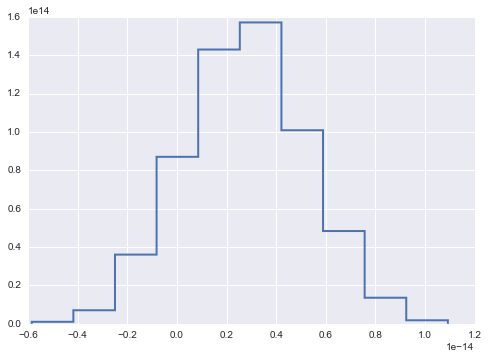

In [47]:
(common.raJ2000_1 - common.phiprime_1).hist(normed=1, histtype='step', lw=2.)

In [48]:
(common.decJ2000_1 + common.thetaprime_1 - np.pi/2.).describe()

count    2.280000e+03
mean    -8.862307e-18
std      1.613494e-16
min     -4.440892e-16
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.440892e-16
dtype: float64

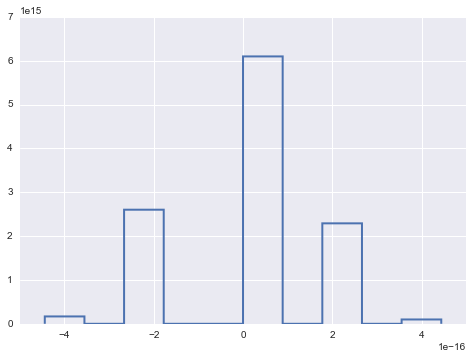

In [49]:
(common.decJ2000_1 + common.thetaprime_1 - np.pi/2.).hist(normed=1, histtype='step', lw=2.)

In [50]:
NSelect = 1000
sel = np.random.choice(common.index.values, NSelect*2, replace=False)

In [51]:
split_1 = common.ix[sel[:NSelect]]
split_2 = common.ix[sel[NSelect:]]

In [52]:
print(len(split_1), len(split_2))

1000 1000


In [53]:
split_1.head()

,galtileid,raJ2000,decJ2000,redshift,mass_stellar,absmag_r_total,galtileid_1,raJ2000_1,decJ2000_1,redshift_1,mass_stellar_1,absmag_r_total_1,theta,phi,phiprime_1,thetaprime_1
id,,,,,,,,,,,,,,,,
12289238,2212289238,0.035547,0.000414,0.3653,0.003186,-14.60432,2112289238,0.035549,-0.069400,0.3653,0.003186,-14.60432,1.570383,0.000641,0.035549,1.640196
5340380,2205340380,0.036637,0.000231,0.3654,0.010732,-16.11604,2105340380,0.036641,-0.069582,0.3654,0.010732,-16.11604,1.570565,0.001731,0.036641,1.640378
16723492,2216723492,0.035407,0.000038,0.3869,0.000142,-13.51893,2116723492,0.035408,-0.069775,0.3869,0.000142,-13.51893,1.570758,0.000501,0.035408,1.640571
112389,2200112389,0.034678,-0.001217,0.3393,0.278545,-19.99513,2100112389,0.034677,-0.071030,0.3393,0.278545,-19.99513,1.572014,-0.000229,0.034677,1.641827
479372,2200479372,0.033443,-0.000500,0.2332,0.068397,-18.08150,2100479372,0.033439,-0.070313,0.2332,0.068397,-18.08150,1.571296,-0.001464,0.033439,1.641109


In [54]:
from lsst.sims.utils import haversine

In [55]:
df = pd.DataFrame({'ids_1': split_1.index.values,
                   'ids_2': split_2.index.values,
                   'raJ2000': split_1.raJ2000.values,
                   #'shiftedRA':split_1.shiftedRA.values,
                   'decJ2000':split_1.decJ2000.values,
                   'raJ2000_2': split_2.raJ2000.values,
                   #'shiftedRA_2': split_2.shiftedRA_1.values,
                   'decJ2000_2':split_2.decJ2000.values,
                   'angsep': haversine(split_1.decJ2000.values, split_1.raJ2000.values, split_2.decJ2000.values, 
                                       split_2.raJ2000.values),
                  'angsep_1': haversine(split_1.decJ2000_1.values, split_1.raJ2000_1.values, split_2.decJ2000_1.values, 
                                       split_2.raJ2000_1.values),
                  'angSep': angSep(split_1, split_2, 'theta', 'phi')[1] ,
                  'angSep_1':angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')[1],
                  'cosval': angSep(split_1, split_2, 'theta', 'phi')[0] ,
                   'cosval_1': angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')[0] 
                  }
                   #'angsep_1': haversine(split_1.decJ2000_1, split_1.raJ2000_1, split_2.decJ2000_1, split_2.raJ2000_1)}
                  )

In [56]:
df['ratio'] = df.angsep_1/df.angsep 

In [57]:
df['theta_ratio'] = df.angSep_1/df.angSep

In [58]:
df.ratio.describe()

count    1000.000000
mean        1.001242
std         0.000851
min         1.000000
25%         1.000421
50%         1.001264
75%         1.002096
max         1.002559
Name: ratio, dtype: float64

In [59]:
df.theta_ratio.describe()

count    1.000000e+03
mean     1.000000e+00
std      3.529738e-09
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: theta_ratio, dtype: float64

(0.99990000000000001101341240428155, 1.00009999999999998898658759571845)

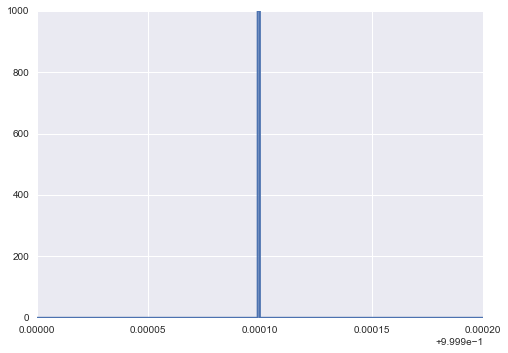

In [60]:
_ = plt.hist(df.cosval_1/np.cos(df.angSep_1), histtype='step', alpha=1, lw=2., bins=np.arange(0.5, 1.5, 0.000001))
plt.xlim(0.9999, 1.0001)

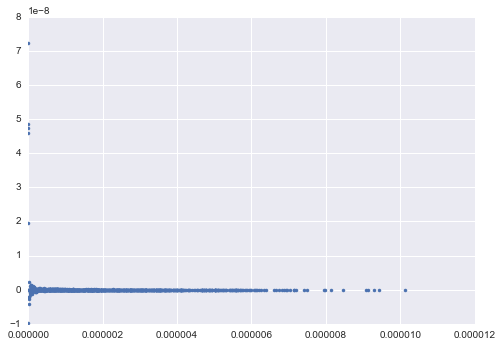

In [61]:
plt.plot(1. - df.cosval, df.angSep_1/df.angSep -1., '.')

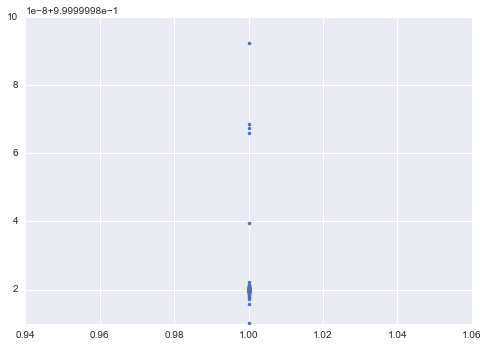

In [62]:
plt.plot(df.cosval_1/df.cosval, df.theta_ratio, '.')

In [63]:
df.ratio.isnull().any()

False

In [64]:
df.theta_ratio.isnull().any()

False

In [65]:
df.theta_ratio.dtype

dtype('float64')

In [66]:
df.head()

,angSep,angSep_1,angsep,angsep_1,cosval,cosval_1,decJ2000,decJ2000_2,ids_1,ids_2,raJ2000,raJ2000_2,ratio,theta_ratio
0,0.000406,0.000406,0.000406,0.000406,1.000000,1.000000,0.000414,0.000682,12289238,1500567,0.035547,0.035243,1.001354,1
1,0.002365,0.002365,0.002364,0.002367,0.999997,0.999997,0.000231,-0.001337,5340380,11577615,0.036637,0.034867,1.001391,1
2,0.001915,0.001915,0.001915,0.001919,0.999998,0.999998,0.000038,-0.000654,16723492,4715406,0.035407,0.033621,1.002143,1
3,0.001790,0.001790,0.001790,0.001792,0.999998,0.999998,-0.001217,-0.000079,112389,1818869,0.034678,0.036059,1.001483,1
4,0.001847,0.001847,0.001847,0.001850,0.999998,0.999998,-0.000500,-0.001320,479372,1499564,0.033443,0.035098,1.002013,1


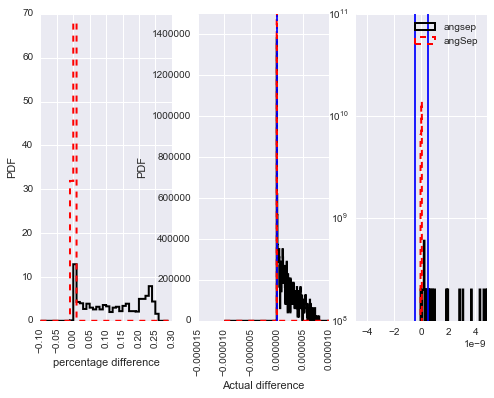

In [150]:
fig, ax = plt.subplots(1,3 , squeeze=True)


_ = ax[0].hist(100.*(df.ratio.values - 1.), bins=np.arange(-0.1, 0.3, 0.01), normed=1,
               histtype='step', alpha=1, lw=2., color='k')
xticks = ax[0].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]

_ = ax[0].hist(100.*(df.theta_ratio.values - 1.), bins=np.arange(-0.1, 0.3, 0.01), 
               normed=1,
               histtype='step', alpha=1, lw=2., color='r', ls='dashed')



# sns.kdeplot(df.ratio - 1., ax=ax)
ax[0].set_xlabel('percentage difference')
ax[0].set_ylabel('PDF')
_ = ax[1].hist((df.ratio.values - 1.)*df.angsep,normed=1, bins=np.arange(-0.00001, 0.00001, 10.* milliarcsec),
        histtype='step', alpha=1, lw=2., color='k')
_ = ax[1].hist((df.theta_ratio.values - 1.)*df.angSep,normed=1, bins=np.arange(-0.00001, 0.00001, 10.* milliarcsec),
        histtype='step', alpha=1, lw=2., color='r', ls='dashed')
#ax[1].axvline(np.radians(1.0/60./60.), ls='dashed')
ax[1].axvline(10* milliarcsec, ls='dashed')
ax[1].set_ylim(ymax=1500000)
xticks = ax[1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
# sns.kdeplot(df.ratio - 1., ax=ax)
ax[1].set_xlabel('Actual difference')
ax[1].set_ylabel('PDF')
_ = ax[2].hist((df.ratio.values - 1.)*df.angsep,normed=1, bins=np.arange(-20.*milliarcsec, 20.*milliarcsec,  
                                                                         milliarcsec/100.),
        histtype='step', alpha=1, lw=2., color='k')


_ = ax[2].hist((df.theta_ratio.values - 1.)*df.angSep,normed=1, bins=np.arange(-20.*milliarcsec, 20.*milliarcsec, 
                                                                               milliarcsec/100),
        histtype='step', alpha=1, lw=2., color='r', ls='dashed')
ax[2].axvline(milliarcsec/10)
ax[2].axvline(-milliarcsec/10)
ax[2].set_xlim(-milliarcsec, milliarcsec)
_ = ax[2].set_yscale('log')
plt.legend(loc='best')

# Scratch

In [ ]:
fig, ax = plt.subplots(1,2)
_ = ax[0].hist(common.decJ2000_1 + common.thetaprime_1 - np.pi/2., histtype='step', alpha=1., lw=2.)
_ = ax[1].hist(common.raJ2000_1 + common.phiprime_1, histtype='step', alpha=1., lw=2.)
xticks = ax[1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]




In [ ]:
def angSep( df1 , df2,  theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

In [ ]:
theta_df= pd.DataFrame({'ids_1': split_1.index.values,
                   'ids_2': split_2.index.values,
                   'raJ2000': split_1.raJ2000.values,
                   #'shiftedRA':split_1.shiftedRA.values,
                   'decJ2000':split_1.decJ2000.values,
                   'raJ2000_2': split_2.raJ2000.values,
                   #'shiftedRA_2': split_2.shiftedRA_1.values,
                   'decJ2000_2':split_2.decJ2000.values,
                   'angSep': angSep(split_1, split_2, 'theta', 'phi') ,
                   'angSep_1':angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')})

In [ ]:
# Use if not using base tile
fig, ax = plt.subplots(2, 3, sharey=True, squeeze=False)
ax[0,0].plot(df.angsep, df.ratio-1, '.')
xticks = ax[0, 0].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 0].set_xlabel('orig ang sep')
ax[0, 0].xaxis.set_label_position('top') 
ax[0, 1].plot(df.decJ2000 - df.decJ2000_2, df.ratio - 1, '.')
ax[0, 1].set_xlabel('diff in dec for 2 pts')
ax[0, 1].xaxis.set_label_position('top') 
xticks = ax[0, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].plot(df.raJ2000 - df.raJ2000_2, df.ratio - 1, '.r')
xticks = ax[0, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].set_xlabel('diff in ra for 2 pts')
ax[0, 2].xaxis.set_label_position('top') 


ax[1, 1].plot(df.decJ2000, df.ratio - 1, '.')
xticks = ax[1, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 1].set_xlabel('dec in Base')
ax[1, 2].plot(df.raJ2000, df.ratio - 1, '.')
xticks = ax[1, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 2].set_xlabel('ra in Base')


#ax[1,0].plot(df.angsep, (df.ratio -1)* df.angsep, '.')

## Rotations

In [ ]:
common['theta'] = - common['decJ2000'] + np.pi/2.
common['phi'] = common['raJ2000'] - np.radians(2.)

In [ ]:
common.head()

In [ ]:
def rotation(df, delta=0):
    """
    delta : int
    """
    d = delta
    delta = np.radians(delta * 4.0)
    cosDelta = np.cos(delta)
    sinDelta = np.sin(delta)
    
    df['theta'] = - df['decJ2000'] + np.pi/2.
    df['phi'] = df['raJ2000'] - np.radians(2.)
    sintheta = np.sin(df.theta)
    costheta = np.cos(df.theta)
    cosphi = np.cos(df.phi)
    # sinphi = np.sin(df.phi)
    
    zprime =  costheta * cosDelta - sinDelta * sintheta * cosphi
    xprime = sintheta * cosphi * cosDelta + costheta * sinDelta
    # yprime = sintheta * sinphi
    
    #rlat = np.sqrt(xprime **2. + yprime **2.)
    rlat = np.sqrt(1.0 - zprime**2)
    #print(min(rlat), max(rlat))
    thetaprime = 'thetaprime_{}'.format(int(d))
    phiprime = 'phiprime_{}'.format(d)
    df[phiprime] = np.arccos(xprime / rlat) + np.radians(2.)
    #df['x'] = sintheta * cosphi
    #df['y'] = sintheta * sinphi
    #df['z'] = costheta
    #df['xprime'] = xprime
    #df['yprime'] = yprime
    #df['zprime'] = zprime
    df[thetaprime] = np.arccos(zprime)
    #df[thetaprime] = np.arctan(rlat/zprime) 
    #df.thetaprime[df[thetaprime] < 0 ] += np.pi
    #df[thetaprime] = np.arcsin(np.sqrt(xprime**2. + yprime**2))#*np.sign(zprime)
    # df[thetaprime] = np.arcsin(rlat) * np.sign(zprime)

In [ ]:
rotation(common, delta=1)

In [ ]:
common.head()

In [ ]:
np.radians(2.)

In [ ]:
#common['deltaDec'] = common.decJ2000_1 + common.thetaprime_1 - np.pi/2.

In [ ]:
#common['deltaRA'] = common.raJ2000_1 - common.phiprime_1 - np.radians(2.)

In [ ]:
_ = plt.hist(common.raJ2000_1 - common.phiprime_1, bins=np.arange(-0.004, 0.001, 0.0001), histtype='step', lw=2., alpha=1.,
            normed=1)

In [ ]:
def angSep( df1 , df2,  theta, phi):
    th1 = df1[theta].values
    th2 = df2[theta].values
    ph1 = df1[phi].values
    ph2 = df2[phi].values

    cos = np.sin(th1)* np.sin(th2)* np.cos(ph1- ph2) + np.cos(th1)*np.cos(th2)
    return cos

In [ ]:
split_1.columns

In [ ]:
angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1') - angSep(split_1, split_2, 'theta', 'phi')

In [ ]:
theta_df= pd.DataFrame({'ids_1': split_1.index.values,
                   'ids_2': split_2.index.values,
                   'raJ2000': split_1.raJ2000.values,
                   #'shiftedRA':split_1.shiftedRA.values,
                   'decJ2000':split_1.decJ2000.values,
                   'raJ2000_2': split_2.raJ2000.values,
                   #'shiftedRA_2': split_2.shiftedRA_1.values,
                   'decJ2000_2':split_2.decJ2000.values,
                   'angSep': angSep(split_1, split_2, 'theta', 'phi') ,
                   'angSep_1':angSep(split_1, split_2, 'thetaprime_1', 'phiprime_1')})

In [ ]:
theta_df['ratio'] = theta_df.angSep_1 / theta_df.angSep

In [ ]:
_ = ax[0].hist(100.*(theta_df.ratio - 1), bins=np.arange(-0.1, 0.3, 0.01), normed=1, histtype='step', lw=2., alpha=1., color='r')
_ = ax[1].hist((theta_df.ratio.values - 1.)*theta_df.angSep,normed=1, bins=np.arange(-0.00001, 0.00001, 0.000001),
        histtype='step', alpha=1, lw=2., color='r')

In [ ]:
fig_hist

In [ ]:
common.head()

In [ ]:
# Use shifts to take care of periodicity of ra newar ra=0.
fig, ax = plt.subplots(2, 3, sharey=True, squeeze=False)
ax[0,0].plot(df.angsep, df.ratio-1, '.')
xticks = ax[0, 0].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 0].set_xlabel('orig ang sep')
ax[0, 0].xaxis.set_label_position('top') 
ax[0, 1].plot(df.decJ2000 - df.decJ2000_2, df.ratio - 1, '.')
ax[0, 1].set_xlabel('diff in dec for 2 pts')
ax[0, 1].xaxis.set_label_position('top') 
xticks = ax[0, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].plot(df.shiftedRA - df.shiftedRA_2, df.ratio - 1, '.r')
xticks = ax[0, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[0, 2].set_xlabel('diff in ra for 2 pts')
ax[0, 2].xaxis.set_label_position('top') 


ax[1, 1].plot(df.decJ2000, df.ratio - 1, '.')
xticks = ax[1, 1].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 1].set_xlabel('dec in Base')
ax[1, 2].plot(df.shiftedRA, df.ratio - 1, '.')
xticks = ax[1, 2].get_xticklabels()
_ = [xtick.set_rotation(90.) for xtick in xticks]
ax[1, 2].set_xlabel('ra in Base')


#ax[1,0].plot(df.angsep, (df.ratio -1)* df.angsep, '.')

In [ ]:
print(len(df))a


In [ ]:
print(len(merged))

## Scratch

In [ ]:
df.raJ2000.max()

In [ ]:
df.raJ2000.min()

In [ ]:
gTile1_df.raJ2000_1.min()

In [ ]:
gTile1_df.raJ2000_1.max()

In [ ]:
gBase_df.raJ2000.min()

In [ ]:
np.degrees(gBase_df.raJ2000.max())